# Week 04 seminar: Finetuning. 

In [1]:
import os
import time
import requests
from tqdm.auto import trange, tqdm
from copy import deepcopy
from collections import defaultdict

import numpy as np
import pandas as pd

# charts and display libs
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

# pytorch 
import torch
import torchvision
from torchvision import transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_num_threads(min(4, torch.get_num_threads()))  # limit # of threads

print(f"{torch.__version__=}, {torchvision.__version__=}, {device=}, {torch.get_num_threads()=}")

torch.__version__='1.13.1', torchvision.__version__='0.14.1', device=device(type='cuda'), torch.get_num_threads()=4


# Imagenet

Today we're going to use and fine-tune CNN based on weights pre-trained on ImageNet.

What is Imagenet?
- large size image classification dataset.
    - ImageNet-1K contains 1,281,167 training images, 50,000 validation images and 100,000 test images.
    - Full original dataset (ImageNet-21k) contains 14,197,122 images divided into 21,841 classes
    - Resolution varies, average resolution: 469x387 pixels
- built pre-2010 by [Fei-Fei Li](https://en.wikipedia.org/wiki/Fei-Fei_Li) at Princeton 
- made very popular by ImageNet Large Scale Visual Recognition Challenge (ILSVRC). See AlexNet moment: [chart](https://www.researchgate.net/figure/ImageNet-Competition-Results-50_fig1_329975404), [wiki](https://en.wikipedia.org/wiki/AlexNet), [paper](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
-  still relevant; [accuracy history 2013 to date](https://paperswithcode.com/sota/image-classification-on-imagenet)
- More about Imagenet: http://image-net.org/,  https://en.wikipedia.org/wiki/ImageNet

In [2]:
%%html
<div style="height: 200px; overflow: hidden;"><img src="https://cs.stanford.edu/people/karpathy/cnnembed/cnn_embed_full_1k.jpg"></div>

In [3]:
# loading Imagenet class labels
LABELS_URL = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
imagenet_labels = {int(k):v[1] for k, v in requests.get(LABELS_URL).json().items()}
print(len(imagenet_labels), '\n', list(imagenet_labels.items())[:5])

1000 
 [(0, 'tench'), (1, 'goldfish'), (2, 'great_white_shark'), (3, 'tiger_shark'), (4, 'hammerhead')]


## TorchVision

[Torchvision](https://pytorch.org/vision/main/index.html) - part of PyTorch library with convenient tools and data for deep learning in visual domain.
- contains a number of popular vision [datasets](https://pytorch.org/vision/stable/datasets.html)
- preprocessing [tools](https://pytorch.org/vision/stable/transforms.html) 
- and most importantly, [pre-trained models](https://pytorch.org/vision/main/models.html).

## Pretrained models, Resnet


Torchvision models classification models with benchmarks may be viewed [here.](https://pytorch.org/vision/main/models.html#classification)

For this seminar we're going to use Pytorch implementation of popular Resnet model.

In [4]:
%%html
<div style="width: 1000px; height: 150px; overflow: hidden;"><img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/resnet_architecture.png"></div>

In [5]:
# loading pretrained Resnet-18 model
from torchvision.models import resnet18, ResNet18_Weights

model = resnet18(weights=ResNet18_Weights.DEFAULT) # load model with best available weights
model = model.to(device)  # move the model to GPU if available
model.train(False)        # set the model to evaluation mode

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/optimus/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### testing the pretrained model 1

In [6]:
# test output dimensions
dummy_x = torch.randn(5, 3, 224, 224, device=device)  # dummy batch of 5 'images' sized 224x224 with 3 channels, created on GPU
result = model(dummy_x)
assert result.shape == (5, 1000)   # logits of 1000 classes for 5 images

### testing the pretrained model 2. Predict class probabilities.

In [7]:
# UNCOMMENT AND RUN IF USING COLAB
# !mkdir -p sample_images
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall22/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

(224, 224)


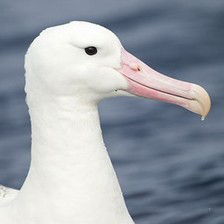

In [9]:
# loading image with PIL library
img = Image.open('sample_images/albatross.jpg')
print(img.size)
img

In [10]:
# converting PIL image to torch.Tensor
img_torch = torch.tensor(np.array(img), device=device).permute(2,0,1) / np.array(img).max()  # to np.array, to torch.Tensor, reorder color channels, add batch dim, scale to 0..1 
img_torch.shape, img_torch.device, img_torch.min().item(), img_torch.max().item()

(torch.Size([3, 224, 224]), device(type='cuda', index=0), 0.0, 1.0)

In [11]:
# PIL image to torch.Tensor, now with torchvision.transforms  (more details below)
%time img_torch = transforms.ToTensor()(img)
img_torch.shape, img_torch.max(), img_torch.min()

CPU times: user 1.95 ms, sys: 2.94 ms, total: 4.88 ms
Wall time: 5.37 ms


(torch.Size([3, 224, 224]), tensor(1.), tensor(0.))

In [12]:
# Predicting image class with pretrained model

def predict(img, model):
    img_torch = torch.tensor(np.array(img), device=device).permute(2,0,1) / np.array(img).max()
    # img = transforms.ToTensor()(img)  # to torch.Tensor, reorder color channels, scale to 0..1 
    img_torch = img_torch.unsqueeze(0)  # add batch dimension 
    prediction = model(img_torch)
    probs = torch.nn.functional.softmax(prediction, dim=-1)
    probs = probs.cpu().data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-11:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print (f"{probs.ravel()[l]:>6.2%}  {imagenet_labels[l].split(',')[0]}")


predict(img, model)

top-10 classes are: 
 [prob : class label]
98.63%  albatross
 0.48%  spoonbill
 0.39%  American_egret
 0.22%  goose
 0.13%  crane
 0.08%  pelican
 0.01%  little_blue_heron
 0.01%  flamingo
 0.01%  white_stork
 0.01%  limpkin


### testing the pretrained model 3: Images from unknown classes

(369, 297)


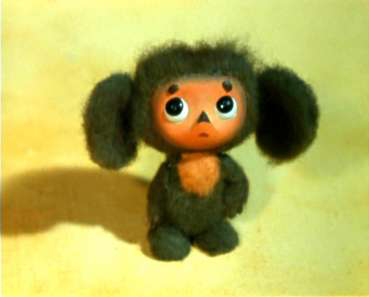

top-10 classes are: 
 [prob : class label]
 2.02%  ping-pong_ball
 1.73%  saltshaker
 1.59%  screen
 1.45%  tray
 1.44%  bathtub
 1.35%  thimble
 1.33%  tub
 1.01%  Band_Aid
 0.97%  laptop
 0.95%  hair_slide


In [31]:
url = 'https://upload.wikimedia.org/wikipedia/ru/f/f9/Film_2567_03.jpg'  # original
# url= 'https://cdn5.vedomosti.ru/crop/image/2023/a/khwog/original-qkb.png?height=349&width=620'  # modern
# url = 'https://icdn.lenta.ru/images/2020/04/23/16/20200423160206740/detail_5d66d296d9fcfd16c65acbcd7a346f18.png'  # japanese

# url = 'https://upload.wikimedia.org/wikipedia/ru/7/77/Pikachu.png'

# url = 'https://animalfactguide.com/wp-content/uploads/2013/01/EATING2.jpg'
# url = 'https://upload.wikimedia.org/wikipedia/en/3/3d/Po_from_DreamWorks_Animation%27s_Kung_Fu_Panda.png'
# <TRY ANY OTHER IMAGES YOU LIKE>

web_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')
print(web_img.size)
display(web_img)
predict(web_img, model)

## More Torchvision tools: Transforms and transform pipelines¶

In [16]:
from torchvision import transforms

transform_pipeline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.ConvertImageDtype(torch.float32),  # optional
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize according to ImageNet standards
])

# img = torchvision.io.read_image('img.jpg')
img = Image.open('sample_images/albatross.jpg')
img_torch = transform_pipeline(img)

print(type(img_torch), img_torch.shape)

<class 'torch.Tensor'> torch.Size([3, 224, 224])


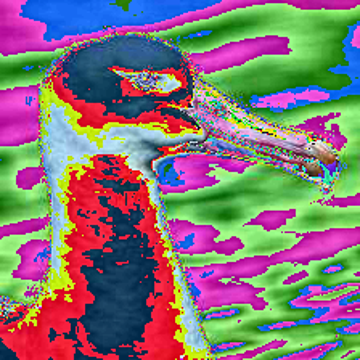

In [17]:
display(transforms.ToPILImage()(img_torch.squeeze()).resize((360, 360)))

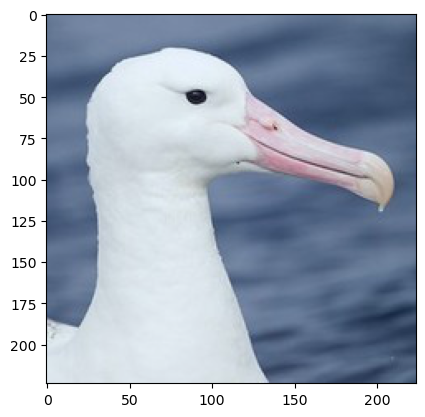

In [18]:
# unmessing transformed image after normalization
img2 = img_torch.cpu().numpy().transpose(1,2,0)
img2 -= img2.min()
img2 /= img2.max()
plt.imshow(img2);

## Classifying with CNN model's latent features

In this seminar your goal is to fine-tune a pre-trained model to distinguish between cats and dogs

The first step is to just reuse some network layer as features

### How to get features
features = activations before the very last FC layer of the model.

During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [19]:
embedding_model = deepcopy(model).to(device)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        # <YOUR CODE>
        return x
        
# same as torch.nn.Identity() - check yourself: https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Identity
    
# redefine the last layer to be Identity
embedding_model.fc = Identity().to(device)

check yourself: should be close to torch.nn.Identity(): https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Identity

In [20]:
img = Image.open('sample_images/albatross.jpg')
img_torch = transforms.ToTensor()(img).unsqueeze(0).to(device)
out = embedding_model(img_torch).cpu().data.numpy()
assert out.shape == (1, 512), "your output for single image should have shape (1, 512)"

## for starters: cat-dog classification
<!-- 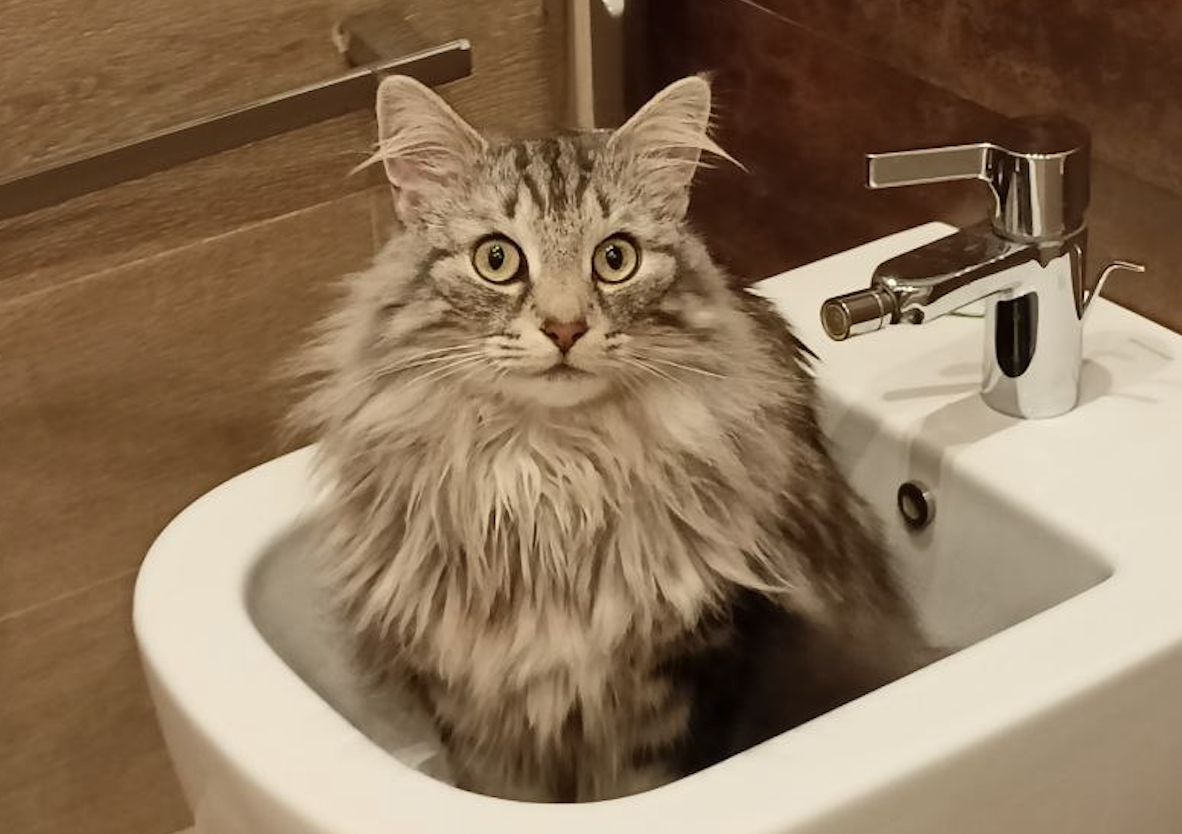 -->
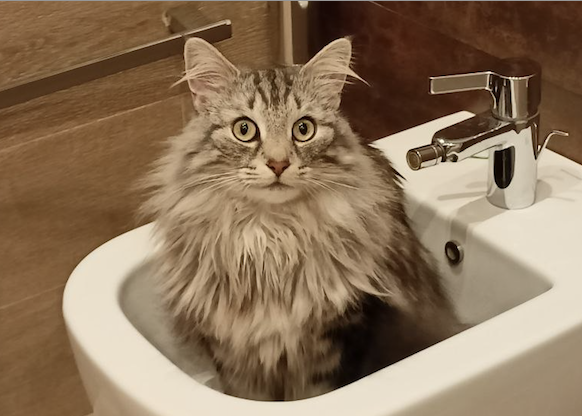

In [ ]:
!wget https://storage.yandexcloud.net/yandex-research/courses/dogs_vs_cats_1000.zip -O dogs_vs_cats_1000.zip

In [ ]:
!unzip -q dogs_vs_cats_1000.zip
!ls dogs_vs_cats_1000 | wc -l

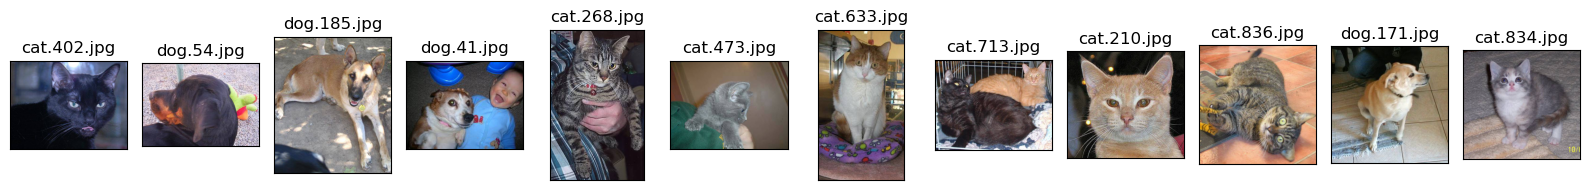

In [24]:
# Sample pets images
fig, axs = plt.subplots(1, 12, figsize=(16, 2))

fnames = [fn for fn in os.listdir('dogs_vs_cats_1000') if fn.endswith('jpg')]
for ax, fname in zip(axs.ravel(), fnames):
    img_ = Image.open(os.path.join('dogs_vs_cats_1000', fname))
    ax.imshow(img_)
    ax.set_title(f"{fname}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [ ]:
X_ = []
Y_ = []

batch_size =   # <YOUR VALUE>
x_batch = torch.zeros([batch_size, 3, 224, 224])
y_batch = []
batch_index = 0

with torch.no_grad():
    for fname in tqdm(os.listdir('train')):
        if int(fname[4:-4]) < 100:  # use under 1000 images from each class

            y_batch.append(1 if fname.startswith("cat") else 0)

            img = Image.open(os.path.join("train", fname))
            img_torch = transforms.ToTensor()(img.resize((224, 224)))
            x_batch[batch_index] = img_torch

            if batch_index == batch_size - 1:
                # use your embedding model to produce feature vector
                # and save relevant data to X_, Y_
                # <YOUR CODE>
                
                # <END YOUR CODE>
                batch_index = 0                
                continue

            batch_index += 1

In [ ]:
X = np.concatenate(X_, axis = 0)  # concatenate all batches' embeddings into single 2D array. 
Y = np.concatenate(Y_, axis = 0)  # concatenate all batches' labels into single 1D array.

assert X.ndim == 2 and X.shape[1] == 512   # and 1800 <= X.shape[0] <= 2000
assert Y.ndim == 1 and Y.shape[0] == X.shape[0]
assert 0.47 <= np.mean(Y) <= 0.53

print(X.shape, Y.shape, np.mean(Y))

### embeddings classification with ML-1 tools

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

* Train sklearn model, evaluate validation accuracy (should be >90%)

In [ ]:
%%time 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

# <YOUR CODE HERE>


# <END YOUR CODE>
print(f"accuracy = {(Y_pred == Y_test).sum() / Y_pred.shape[0]:.1%}")

## Torchvision Datasets
- Built-in datasets https://pytorch.org/vision/stable/datasets.html#built-in-datasets

- Datasets and Dataloaders at `torch.utils.data`: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Torchvision classes for custom datasets  https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets

## Oxford pets dataset

Dataset home page: https://www.robots.ox.ac.uk/~vgg/data/pets/

Available from Pytorch: https://pytorch.org/vision/stable/generated/torchvision.datasets.OxfordIIITPet.html#torchvision.datasets.OxfordIIITPet



In [25]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    # transforms.ConvertImageDtype(torch.float32),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Optional: normalize according to ImageNet standards
])

train_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='trainval', target_types='category', download=True, transform=test_transform)
test_dataset = torchvision.datasets.OxfordIIITPet(root='.', split='test', target_types='category', download=True, transform=test_transform)

  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/images.tar.gz to oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting oxford-iiit-pet/annotations.tar.gz to oxford-iiit-pet


In [26]:
len(train_dataset), len(test_dataset)

(3680, 3669)

In [27]:
print(train_dataset.classes)

['Abyssinian', 'American Bulldog', 'American Pit Bull Terrier', 'Basset Hound', 'Beagle', 'Bengal', 'Birman', 'Bombay', 'Boxer', 'British Shorthair', 'Chihuahua', 'Egyptian Mau', 'English Cocker Spaniel', 'English Setter', 'German Shorthaired', 'Great Pyrenees', 'Havanese', 'Japanese Chin', 'Keeshond', 'Leonberger', 'Maine Coon', 'Miniature Pinscher', 'Newfoundland', 'Persian', 'Pomeranian', 'Pug', 'Ragdoll', 'Russian Blue', 'Saint Bernard', 'Samoyed', 'Scottish Terrier', 'Shiba Inu', 'Siamese', 'Sphynx', 'Staffordshire Bull Terrier', 'Wheaten Terrier', 'Yorkshire Terrier']


In [ ]:
print("dataset sizes:", len(train_dataset), len(test_dataset))

num_workers = 0
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=num_workers)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=num_workers)
print("dataloader sizes:", len(train_dataloader), len(test_dataloader))

In [ ]:
for x_batch, y_batch in train_dataloader:
    break

In [ ]:
# Sample pets images
fig, axs = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    ax.imshow(x_batch[i].permute(1, 2, 0))
    label = train_dataset.classes[y_batch[i]]
    ax.set_title(f"{label}")
    ax.tick_params(left = False,labelleft = False , labelbottom = False, bottom = False)
plt.tight_layout()

In [ ]:
# Predicting breeds with Imagenet-pretrained model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)
        
Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

In [ ]:
# Obtain top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overal, mismatch in label spaces.

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label":cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-3:][::-1]
    for j, l in enumerate(top_ix):
        class_stats.update({f"pred_{j+1}": imagenet_labels[l], 
                            f"prob_{j+1}": probs1.ravel()[l]})
    # results_list.append(class_stats)
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T #.set_index('true_label')
float_cols = ['prob_1', 'prob_2', 'prob_3']
df.style.format('{:.2%}', subset=float_cols)

## Finetuning CNN

In [ ]:
ft_model = deepcopy(model).to(device)
for p in ft_model.parameters():
     p.requires_grad = False
        
ft_model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=len(train_dataset.classes), device=device)
assert ft_model.fc.weight.requires_grad
assert not ft_model.conv1.weight.requires_grad

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.001)

In [ ]:
num_epochs = 30

history = defaultdict(list)
for epoch in range (num_epochs):
    start_time = time.time()
    
    ft_model.train()
    train_losses = []
    pbar = tqdm(train_dataloader, leave=False)    
    for x_batch, y_batch in pbar:
        
        # <YOUR CODE HERE>
        
        train_losses.append(loss.item())
        pbar.desc = f"Train. Ep:{epoch}, Loss:{np.mean(train_losses[-10:]):.5f}"
        
    ft_model.eval()
    val_losses = []
    val_cnt, val_correct = 0, 0
    pbar = tqdm(test_dataloader, leave=False)
    for x_batch, y_batch in pbar:

        # <YOUR CODE HERE>
        
        val_losses.append(loss.item())
        val_cnt += y_batch.shape[0]
        val_correct += (y_batch.cuda() == torch.argmax(y_pred, dim=1)).sum().item()
        pbar.desc = f"Valid. Ep:{epoch}, Loss:{np.mean(val_losses):.5f}"

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    accuracy = val_correct / val_cnt
    history['train_loss'].append(train_loss) 
    history['val_loss'].append(val_loss)
    history['accuracy'].append(accuracy)
    print(f"Ep.{epoch:>2}: {train_loss=:.5f}  {val_loss=:.5f}  {accuracy=:.2%}  epoch_time={time.time() - start_time:.1f}s")
    
    if epoch > 2 and history['accuracy'][-1] < max(history['accuracy']):
        break
print(f"Best Accuracy = {max(history['accuracy']):.2%}")

In [ ]:
# Continue training with all layers involved

# <YOUR CODE to make all layers trainable>

assert ft_model.conv1.weight.requires_grad
optimizer = torch.optim.Adam(ft_model.parameters(), lr=0.0001)  # reduce LR to avoid explosion

In [ ]:
# <TRAIN MORE - COPY CODE FROM ABOVE>

In [ ]:
# Predicting breeds with finetuned model
Y_probs, Y_true = [], []
for x_batch, y_batch in tqdm(test_dataloader):
    with torch.no_grad():
        prediction = ft_model(x_batch.to(device))
        probs = torch.nn.functional.softmax(prediction, dim=-1).cpu()
        Y_true.append(y_batch)
        Y_probs.append(probs)
        
Y_probs = torch.cat(Y_probs, axis=0)
Y_true = torch.cat(Y_true)
Y_true.shape, Y_probs.shape

In [ ]:
# Obtain top 3 predictions for each class using pretrained CNN (no finetuning)
# Expect to see high accuracy (70-80%) in some classes, much lower overal, mismatch in label spaces.

results_list = {}

for i, cl in enumerate(test_dataset.classes):
    class_stats = {"true_label":cl}
    probs1 = Y_probs[np.where(Y_true == i)].mean(axis=0).numpy()
    top_ix = probs1.argsort()[-3:][::-1]
    for j, l in enumerate(top_ix):
        class_stats.update({f"pred_{j+1}": test_dataset.classes[l], 
                            f"prob_{j+1}": probs1.ravel()[l]})
    # results_list.append(class_stats)
    results_list[cl] = class_stats

df = pd.DataFrame(results_list).T #.set_index('true_label')
float_cols = ['prob_1', 'prob_2', 'prob_3']
df.style.format('{:.2%}', subset=float_cols)

### Image transforms and augmentations
increase the variability and size of the training data, helping to prevent overfitting and improve model generalization.
- Pytorch augmentations tools: https://pytorch.org/vision/stable/transforms.html
- Albumentations library: https://albumentations.ai/

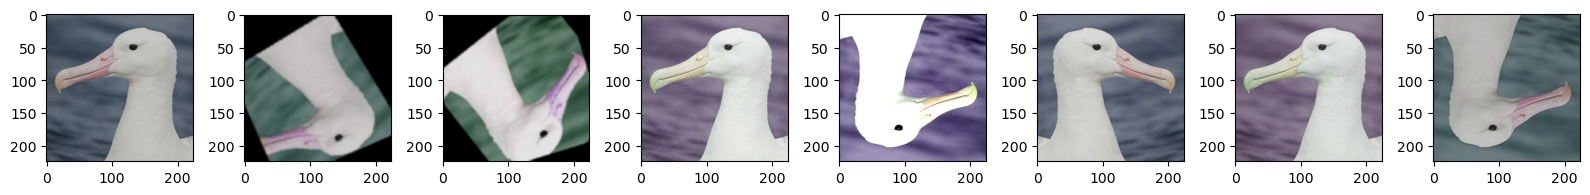

In [28]:
img = Image.open('sample_images/albatross.jpg')

transform_pipeline_2 = transforms.Compose([
    transforms.RandomCrop((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([
        transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
        transforms.RandomRotation(30),
        transforms.GaussianBlur(kernel_size=25),
    ], p=0.5),
    transforms.RandomOrder([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
    ]),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Example normalization values for ImageNet dataset
])

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, ax in enumerate(axs.ravel()):
    img_2 = transform_pipeline_2(img)
    ax.imshow(img_2.permute(1, 2, 0))
plt.tight_layout()

# Main homework quest

### Get the score improved on Oxford Pets dataset classification tasks!
    - Reach [__at least 95%__] accuracy on the test set. More = better.
    - Reach [__at least 80%__] accuracy for each breed in the test set

### suggested methods to start with:
    - Hyperparameters optimization
    - Image augmentation
    - pretrained model selection
    - [balanced loss function]

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

## Tips:

### Train the newly added layer(s) for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      <br>`opt = torch.optim.Adam([head_only.parameters()])`
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
  
### Use Augmentations
* see section

# EXTRA STUFF:


## Links:    
- [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
- [Activations Atlas](https://distill.pub/2019/activation-atlas/)
- more models from https://github.com/huggingface/pytorch-image-models
- Papers with code: benchmarks and model references. https://paperswithcode.com/sota/image-classification-on-imagenet

# Demo 1: #deepdream

![img](https://3.bp.blogspot.com/-4Uj3hPFupok/VYIT6s_c9OI/AAAAAAAAAlc/_yGdbbsmGiw/s640/ibis.png)

https://en.wikipedia.org/wiki/DeepDream

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [ ]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [ ]:
def dd_helper(image, layer, iterations, lr):
    input_var = transforms.ToTensor()(image).unsqueeze(0).to(torch.float32)
    input_var.requires_grad=True
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze().permute(1, 2, 0)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im


def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves > 0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
        image1 = image1.resize(size)
            
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    return img_result

In [ ]:
img = Image.fromarray(plt.imread('sample_images/che.jpg'))
# img.resize((600, 360))

In [ ]:
output = deep_dream(img, layer=7, iterations=5, lr=0.4, octave_scale=2, num_octaves=4)

In [ ]:
#can you implement one class probability optimization to make model dream about bananas
<YOUR CODE>

# Demo 2: Adversarial Attack
<img src="https://pytorch.org/tutorials/_images/fgsm_panda_image.png"  width="40%" height="40%">

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [ ]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image


def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

In [ ]:
img = Image.fromarray(plt.imread('img.jpg'))
img_adv = dd_helper(img, ?, ?, ?)
img_adv

In [ ]:
predict(resize(np.asarray(img_adv), (299, 299)))